In [16]:
# Importy bibliotek
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import xgboost as xgb
from sklearn.cluster import KMeans


In [17]:
# Pliki CSV umieszczone w folderze data
uczestnicy = pd.read_csv('data/PPK_Uczestnicy.csv', sep=';')
pracodawcy = pd.read_csv('data/PPK_Pracodawcy.csv',sep=';')

# Mergowanie dwóch csv
df = pd.merge(
    uczestnicy,
    pracodawcy,
    how='left',
    left_on='EMPL_ID',
    right_on='ID'
)


In [18]:
#Age to int

def to_int(age):
    age = age[:age.find(",")]
    return int(age)

df["AGE"] = df["AGE"].apply(to_int)

In [19]:
# Dropowanie niepotrzebnych kolumn
df.drop(columns=['MEMBER_ID','EMPL_ID', 'WORK_START', 'WORK_STOP', 'LOGICAL_FACTOR_1','LOGICAL_FACTOR_2','ID','PKD_CODE','PPK_BANK','NUMERICAL_VALUE'], inplace=True)

In [20]:
# Grouping other nationalities into one category '0'
unique_nat = df['NATIONALITY'].unique()
for val in unique_nat:
    suma = ( df['NATIONALITY'].values == val ).sum()
    if suma < 5000:
        df.loc[df.NATIONALITY == val, 'NATIONALITY'] = 0       

In [21]:
# zamiana danych kategorycznych na dummy variables - tworzymy nową kolumnę na każdy możliwy output kolumny, porównaj poprzednią i następną komórkę
df = pd.get_dummies(df, columns = ['SEX', 'COMPANY_SIZE', 'COMPANY_TYPE', 'VOIVODESHIP', 'NATIONALITY','PPK_STAGE'], 
                         prefix = ['SEX', 'COMPANY_SIZE', 'COMPANY_TYPE', 'VOIVODESHIP', 'NATIONALITY','PPK_STAGE'])

In [22]:
# 
def find_period(data):
    start, stop = data
    if type(stop) is float:
        stop = datetime.now().strftime("%Y-%m-%d")
    
    start_year, start_month, start_day = map(int, start.split('-'))
    stop_year, stop_month, stop_day = map(int, stop.split('-'))
    
    days = (stop_year - start_year)*365
    days += (stop_month - start_month)*30 if stop_month > start_month else (start_month - stop_month)*30
    days += stop_day - start_day if stop_day > start_day else start_day - stop_day
    
    return days


df['DURATION'] = list(zip(df['SIGN_DATE'], df['RESIGN_DATE']))

df['DURATION'] = df['DURATION'].apply(find_period) 

df['RESIGNED'] = ~df['RESIGN_DATE'].isna()

df.drop(columns = ['SIGN_DATE', 'RESIGN_DATE'], inplace=True)
# z tym nie wiem co mam zrobic, mozna wyjebac albo cos mądrego zrobic
df.drop(columns=["CREATED_AT", "UOZ_START_DATE", "UOP_SIGN_DATE", 'REGION_CODE'], inplace=True)

### wyrzucenie paru kolumn co nie pasują narazie i TEST/TRAIN split

In [23]:
# ta kolumna to w ogole jest 100% skorelowana z targetem, pozdro
df.drop(columns=["RESIGNED"], inplace = True)

# to tez jest podejrzanie skorelowane
# df.drop(columns=["DURATION"], inplace = True)

In [24]:
df.columns


Index(['IS_SUSPENDED', 'AGE', 'HAS_AE', 'HAS_AW', 'HAS_IP', 'SEX_K', 'SEX_M',
       'SEX_N', 'COMPANY_SIZE_A', 'COMPANY_SIZE_B', 'COMPANY_SIZE_C',
       'COMPANY_SIZE_D', 'COMPANY_SIZE_E', 'COMPANY_SIZE_F', 'COMPANY_SIZE_G',
       'COMPANY_SIZE_H', 'COMPANY_TYPE_1.0', 'COMPANY_TYPE_2.0',
       'COMPANY_TYPE_3.0', 'COMPANY_TYPE_4.0', 'COMPANY_TYPE_5.0',
       'COMPANY_TYPE_6.0', 'COMPANY_TYPE_7.0', 'COMPANY_TYPE_9.0',
       'COMPANY_TYPE_10.0', 'COMPANY_TYPE_11.0', 'COMPANY_TYPE_12.0',
       'COMPANY_TYPE_13.0', 'COMPANY_TYPE_14.0', 'COMPANY_TYPE_16.0',
       'COMPANY_TYPE_17.0', 'COMPANY_TYPE_18.0', 'COMPANY_TYPE_19.0',
       'COMPANY_TYPE_20.0', 'COMPANY_TYPE_21.0', 'COMPANY_TYPE_22.0',
       'COMPANY_TYPE_23.0', 'COMPANY_TYPE_24.0', 'COMPANY_TYPE_25.0',
       'VOIVODESHIP_DOLNOŚLĄSKIE', 'VOIVODESHIP_KUJAWSKO-POMORSKIE',
       'VOIVODESHIP_LUBELSKIE', 'VOIVODESHIP_LUBUSKIE',
       'VOIVODESHIP_MAZOWIECKIE', 'VOIVODESHIP_MAŁOPOLSKIE',
       'VOIVODESHIP_OPOLSKIE', 'VOIVOD

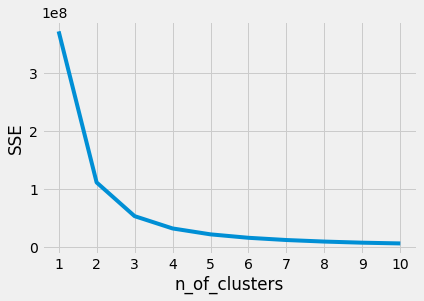

NameError: name 'KneeLocator' is not defined

In [25]:
# Klasteryzacja wieku

dataset = df[['IS_SUSPENDED', 'AGE']]
# dataset = dataset.groupby('AGE').mean()
# dataset.reset_index(inplace=True)

scaled_dataset = dataset.values

kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
    }
   
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_dataset)
    sse.append(kmeans.inertia_)

plt.style.use('fivethirtyeight')
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("n_of_clusters")
plt.ylabel("SSE")
plt.show()


kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
n_of_clusters = kl.elbow

kmeans = KMeans(
    init='random',
    n_clusters = n_of_clusters,
    n_init=50,
    max_iter=500,
    random_state=42
    )

kmeans.fit(scaled_dataset)

df['AGE_CL'] = kmeans.predict(df[["IS_SUSPENDED", "AGE"]])

df.drop(columns=["AGE"], inplace=True)

In [ ]:
#POSITIVE = SUSPENDED jak cos

X_train, X_test, y_train, y_test = train_test_split(df[df.columns[1:]], df["IS_SUSPENDED"], stratify=df["IS_SUSPENDED"], test_size=0.10, random_state=56)
#building the model
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

In [ ]:
y_pred = xgb_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

In [ ]:
df['proba'] = xgb_model.predict_proba(df[X_train.columns])[:,1]
df[['AGE','proba']].head(50)

In [ ]:
# dane testowe
testowe = pd.read_csv('data/PPK_Uczestnicy_TEST.csv',sep=';')

In [ ]:
testowe.columns

In [ ]:
testowe["RESIGN_DATE"].value_counts()

In [ ]:
testowe["RESIGN_DATE"].isna().sum()